# Time series forecasting

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from lstm import LstmNeuralNetwork
from processing import *

# Load the data

We load and plot Tesla stock data from 2010 to 2020.

In [2]:
tesla_data = pd.read_csv('TSLA_2010_2020.csv')
tesla_data = tesla_data.drop(['Date','Open','High','Low','Close'],axis = 1)
total_days = tesla_data.shape[0]
adj_close = tesla_data[['Adj Close']]
volume = tesla_data[['Volume']]
tesla_data.head()

,Adj Close,Volume
0,23.889999,18766300
1,23.830000,17187100
2,21.959999,8218800
3,19.200001,5139800
4,16.110001,6866900


We plot the adjusted value of the tesla stock at the market closure over time

<AxesSubplot:>

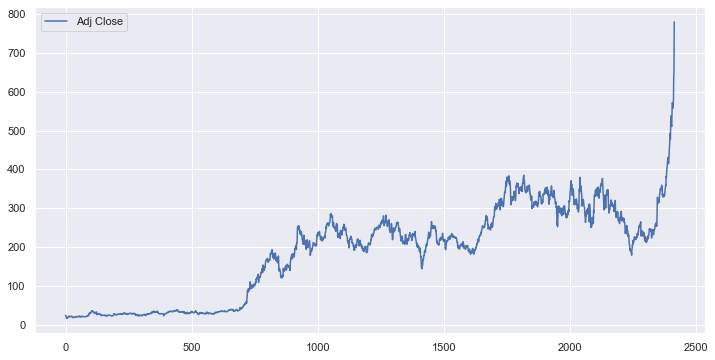

In [3]:
sns.set(rc = {'figure.figsize':(12,6)})
sns.lineplot(
    data = adj_close
)

We plot the exchange volume of the tesla stock over time

<AxesSubplot:>

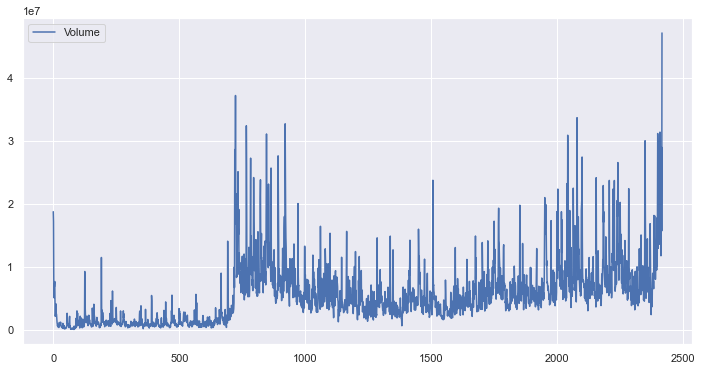

In [4]:
sns.lineplot(
    data = volume
)

# Data processing with adjusted close value

First, we apply a moving average on the "adjusted close" time series to reduce noise. Then, we use a sliding window function that takes the previous days as features and the current day as target. We use the first 2/3 of the time series as our training data set and the rest as our testing set.

In [5]:
seq_length = 15
average_size = 7
train_proportion = 2/3
scaler1 = MinMaxScaler(feature_range=(-1, 1))

y_raw1, X_data1, y_data1, X_train1, y_train1, X_test1, y_test1 = process_data(adj_close, seq_length, average_size, train_proportion, scaler1)

We process the "adjusted close" time series the same way a second time but with a differencing step added at the beginning. 

In [6]:
seq_length = 15
average_size = 7
train_proportion = 2/3
scaler2 = MinMaxScaler(feature_range=(-1, 1))

y_raw2, X_data2, y_data2, X_train2, y_train2, X_test2, y_test2 = process_data_diff(adj_close, seq_length, average_size, train_proportion, scaler2)

# Model definition/training

We create two recurrent neural network model with our LstmNeuralNetwork class

In [7]:
my_model1 = LstmNeuralNetwork(input_size = 1, num_layers = 2, hidden_size = 21, seq_length = seq_length)
my_model2 = LstmNeuralNetwork(input_size = 1, num_layers = 2, hidden_size = 21, seq_length = seq_length)

We train our first model with the raw data

In [18]:
num_epochs = 1000
learning_rate = 0.001
criterion = nn.MSELoss()
my_model1._train(num_epochs, learning_rate, criterion, X_train1, y_train1, X_test1, y_test1)

Epoch: 1000, Train loss: 0.00080, Test loss: 0.03340: 100%|██████████| 1001/1001 [01:51<00:00,  8.95it/s]


We train our second model with the differenciated data

In [12]:
num_epochs = 1000
learning_rate = 0.001
criterion = nn.MSELoss()    
my_model2._train(num_epochs, learning_rate, criterion, X_train2, y_train2, X_test2, y_test2)

Epoch: 1000, Train loss: 0.00090, Test loss: 0.00477: 100%|██████████| 1001/1001 [01:52<00:00,  8.91it/s]


Use this to save our models parameters for future use

In [9]:
filepath1 = 'save/model1'
filepath2 = 'save/model2'
torch.save(my_model1.state_dict(), filepath1)
torch.save(my_model2.state_dict(), filepath2)

Use this to load saved parameters

In [8]:
filepath1 = 'save/model1'
filepath2 = 'save/model2'
my_model1.load_state_dict(torch.load(filepath1))
my_model2.load_state_dict(torch.load(filepath2))

<All keys matched successfully>

# Evaluating/Plotting the results

We compare the accuracy of our predictions with the naive prediction $\hat{y}(t+1 | t) = y(t)$ by computing a mean squared error loss and a $R^2$

In [9]:
last_day = 2380
print('First model accuracy :')
naive_prediction1 = scaler1.inverse_transform(X_data1.numpy()[:,my_model1.seq_length-1])
my_model1.get_accuracy(X_data1, y_data1, naive_prediction1, scaler1, last_day)
print('\n')
print('Second model accuracy :')
naive_prediction2 = np.zeros(y_data2.size(0))
my_model2.get_accuracy(X_data2, y_data2, naive_prediction2, scaler2, last_day)

First model accuracy :
Mean squared error up to the 2380 day using the naive prediction : 5.619442
Mean squared error up to the 2380 day using the lstm prediction : 61.865913
R2 up to the 2380 day using the naive prediction : 0.9995695117548988
R2 up to the 2380 day using the lstm prediction : 0.9952606409808429


Second model accuracy :
Mean squared error up to the 2380 day using the naive prediction : 5.696179904835124
Mean squared error up to the 2380 day using the lstm prediction : 1.4495857
R2 up to the 2380 day using the naive prediction : -0.006498709725168528
R2 up to the 2380 day using the lstm prediction : 0.7438623532749928


We plot our predicitons

<Figure size 864x432 with 0 Axes>

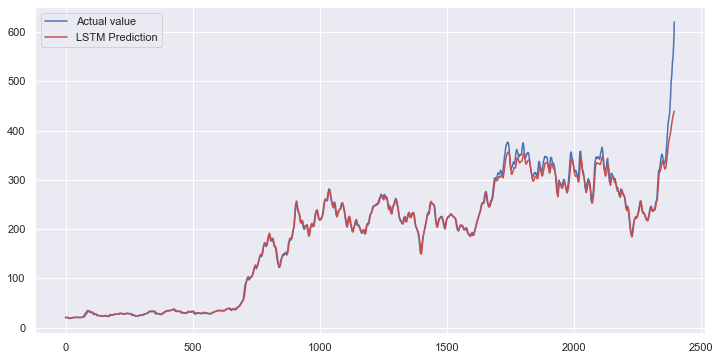

In [10]:
plt.clf()
plt.figure(figsize=(12,6))
my_model1.plot(X_data1, y_data1, scaler1)

<Figure size 864x432 with 0 Axes>

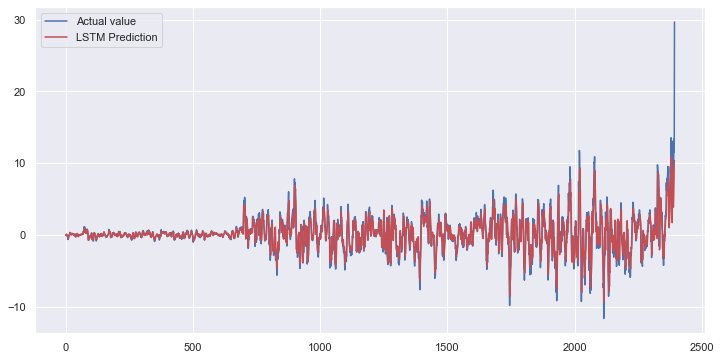

In [11]:
plt.clf()
plt.figure(figsize=(12,6))
my_model2.plot(X_data2, y_data2, scaler2)

Interpretation:

We notice on the MSE that the first model performs poorly as it is worse that the naive prediction. We should not consider the high value of $R^2$ as an evidence of quality of our model. The $R^2$ is high because our time series has a high autocorrelation. On the other hand, the second model (which use the differencing time series) performs well with a $R^2 \simeq 0.74$ while the naive prediction has a $R^2 \simeq -0.01$. We note that we applied a moving average step on our data and if we compare our predictions with the raw target values, we get poor results.

In [12]:
last_day = 2380
print('Second model accuracy with the raw data:')
naive_prediction2 = np.zeros(y_data2.shape[0])
my_model2.get_accuracy(X_data2, y_raw2, naive_prediction2, scaler2, last_day)

Second model accuracy with the raw data:
Mean squared error up to the 2380 day using the naive prediction : 40.943917574578215
Mean squared error up to the 2380 day using the lstm prediction : 44.597527
R2 up to the 2380 day using the naive prediction : -0.0010986810857673834
R2 up to the 2380 day using the lstm prediction : -0.09043124909583922


<Figure size 864x432 with 0 Axes>

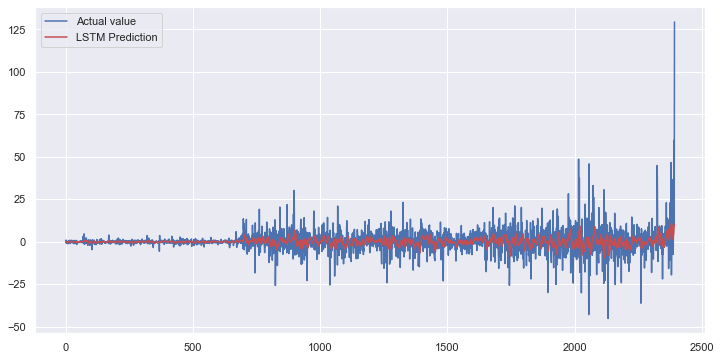

In [13]:
plt.clf()
plt.figure(figsize=(12,6))
my_model2.plot(X_data2, y_raw2, scaler2)

# Forecasting with horizon

In [14]:
last_day = y_data2.shape[0]
horizon_1 = 1
horizon_2 = 3
horizon_3 = 7
horizon_4 = 15
naive_prediction_without_horizon2 = np.zeros(y_data2.shape[0])
print('Model accuracy with horizon = 1: \n')
my_model2.get_accuracy_with_horizon(X_data2, y_data2, naive_prediction_without_horizon2, scaler2, last_day, horizon_1)
print('\nModel accuracy with horizon = 3: \n')
my_model2.get_accuracy_with_horizon(X_data2, y_data2, naive_prediction_without_horizon2, scaler2, last_day, horizon_2)
print('\nModel accuracy with horizon = 7: \n')
my_model2.get_accuracy_with_horizon(X_data2, y_data2, naive_prediction_without_horizon2, scaler2, last_day, horizon_3)
print('\nModel accuracy with horizon = 15: \n')
my_model2.get_accuracy_with_horizon(X_data2, y_data2, naive_prediction_without_horizon2, scaler2, last_day, horizon_4)

Model accuracy with horizon = 1: 

Mean squared error up to the 2394 day using the naive prediction : 6.509801450485878
Mean squared error up to the 2394 day using the lstm prediction : 1.696614082781907
R2 up to the 2394 day using the naive prediction : -0.009729195270762547
R2 up to the 2394 day using the lstm prediction : 0.7368397814399463

Model accuracy with horizon = 3: 

Mean squared error up to the 2394 day using the naive prediction : 6.250972203900683
Mean squared error up to the 2394 day using the lstm prediction : 2.704586470235392
R2 up to the 2394 day using the naive prediction : -0.00936178551834188
R2 up to the 2394 day using the lstm prediction : 0.5632829358956275

Model accuracy with horizon = 7: 

Mean squared error up to the 2394 day using the naive prediction : 6.099917099436713
Mean squared error up to the 2394 day using the lstm prediction : 4.182175940330372
R2 up to the 2394 day using the naive prediction : -0.00880209933758036
R2 up to the 2394 day using the

We notice that our model is able to get the trend for the next 3 days with a $R^2 = 0.56$. With an horizon of 15 however, the lstm predictions ($R^2 = 0.13$) are hardly better than the naive predictions ($R^2 = -0.01$).

<Figure size 864x432 with 0 Axes>

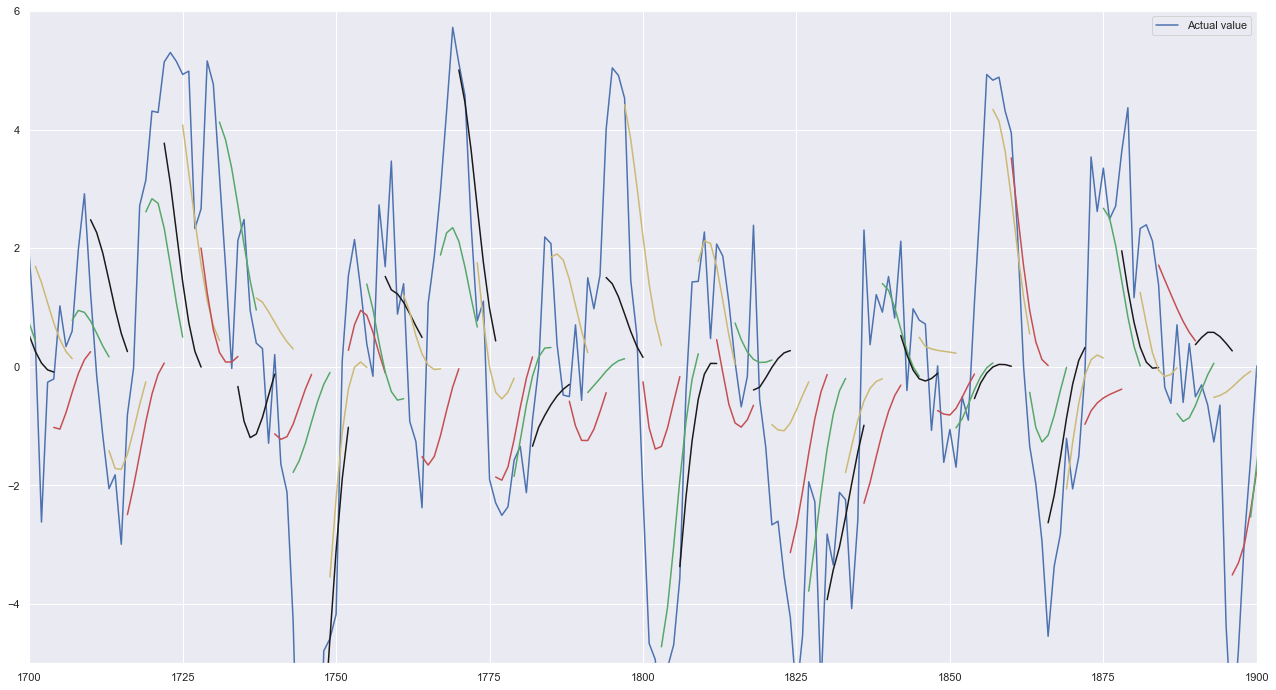

In [21]:
horizon = 7
drawing_jump = 3
plt.clf()
plt.figure(figsize=(22,12))
plt.axis([1700, 1900, -5, 6])
my_model2.plot_with_horizon(X_data2, y_data2, scaler2, horizon, drawing_jump)

# Adding a new feature : the exchange volume

In [16]:
seq_length = 15
average_size = 7
train_proportion = 2/3
scaler3 = MinMaxScaler(feature_range=(-1, 1))

y_raw3, X_data3, y_data3, X_train3, y_train3, X_test3, y_test3 = process_data_diff(tesla_data, seq_length, average_size, train_proportion, scaler3)

In [17]:
my_model3 = LstmNeuralNetwork(input_size = 2, output_size = 2, num_layers = 3, hidden_size = 42, seq_length = seq_length)

In [36]:
num_epochs = 2000
learning_rate = 0.001
criterion = nn.MSELoss()
my_model3._train(num_epochs, learning_rate, criterion, X_train3, y_train3, X_test3, y_test3)

Epoch: 2000, Train loss: 0.00054, Test loss: 0.00281: 100%|██████████| 2001/2001 [11:38<00:00,  2.86it/s]


In [42]:
filepath3 = 'save/model3'
torch.save(my_model3.state_dict(), filepath3)

In [18]:
filepath3 = 'save/model3'
my_model3.load_state_dict(torch.load(filepath3))

<All keys matched successfully>

In [19]:
last_day = y_data3.shape[0]
horizon_1 = 1
horizon_2 = 3
horizon_3 = 7
horizon_4 = 15
naive_prediction_without_horizon3 = np.zeros(last_day)
print('Model accuracy with horizon = 1: \n')
my_model3.get_accuracy_with_horizon(X_data3, y_data3, naive_prediction_without_horizon3, scaler3, last_day, horizon_1)
print('\nModel accuracy with horizon = 3: \n')
my_model3.get_accuracy_with_horizon(X_data3, y_data3, naive_prediction_without_horizon3, scaler3, last_day, horizon_2)
print('\nModel accuracy with horizon = 7: \n')
my_model3.get_accuracy_with_horizon(X_data3, y_data3, naive_prediction_without_horizon3, scaler3, last_day, horizon_3)
print('\nModel accuracy with horizon = 15: \n')
my_model3.get_accuracy_with_horizon(X_data3, y_data3, naive_prediction_without_horizon3, scaler3, last_day, horizon_4)

Model accuracy with horizon = 1: 

Mean squared error up to the 2394 day using the naive prediction : 6.509801450485878
Mean squared error up to the 2394 day using the lstm prediction : 1.5341995224245555
R2 up to the 2394 day using the naive prediction : -0.009729195270762547
R2 up to the 2394 day using the lstm prediction : 0.7620317515141862

Model accuracy with horizon = 3: 

Mean squared error up to the 2394 day using the naive prediction : 6.250972203900683
Mean squared error up to the 2394 day using the lstm prediction : 2.4782140782067406
R2 up to the 2394 day using the naive prediction : -0.00936178551834188
R2 up to the 2394 day using the lstm prediction : 0.5998359126737863

Model accuracy with horizon = 7: 

Mean squared error up to the 2394 day using the naive prediction : 6.099917099436713
Mean squared error up to the 2394 day using the lstm prediction : 4.042367006597461
R2 up to the 2394 day using the naive prediction : -0.00880209933758036
R2 up to the 2394 day using t

<Figure size 864x432 with 0 Axes>

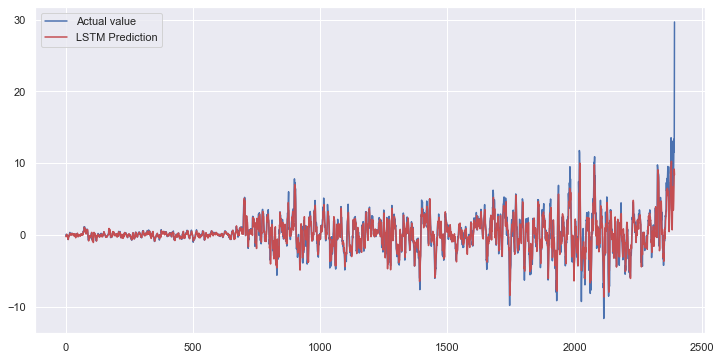

In [20]:
plt.clf()
plt.figure(figsize=(12,6))
my_model3.plot(X_data3, y_data3, scaler3)

<Figure size 864x432 with 0 Axes>

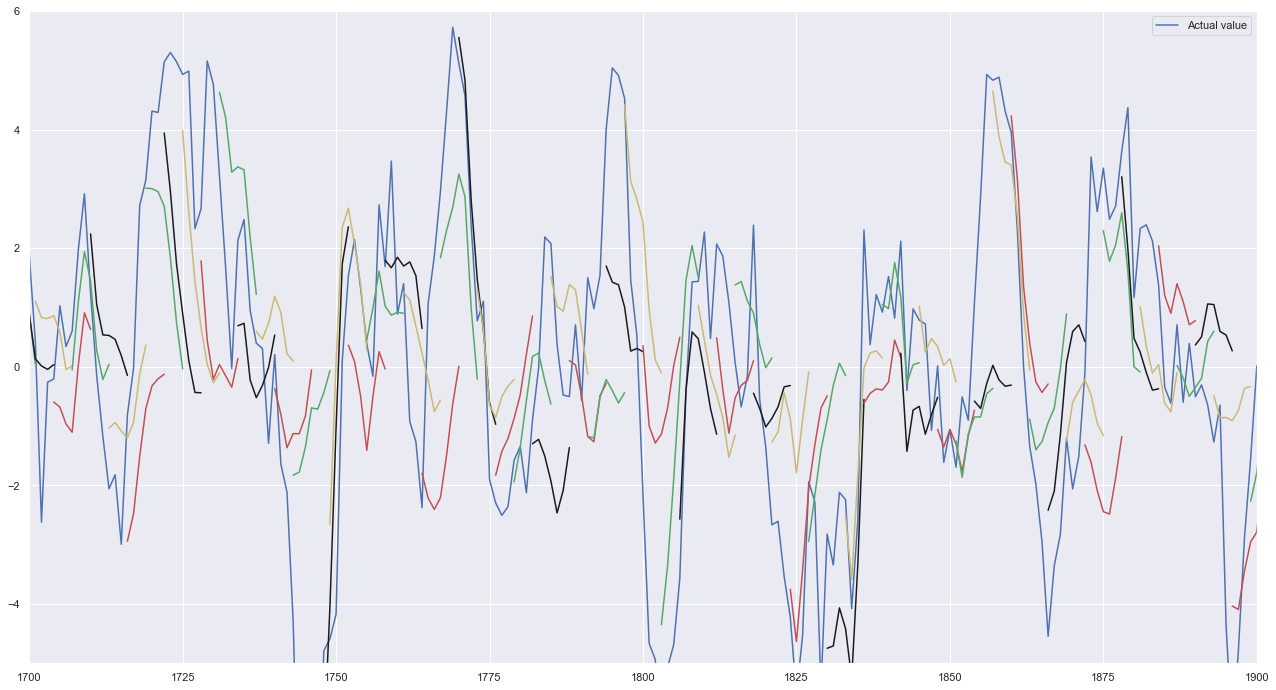

In [22]:
horizon = 7
drawing_jump = 3
plt.clf()
plt.figure(figsize=(22,12))
plt.axis([1700, 1900, -5, 6])
my_model3.plot_with_horizon(X_data3, y_data3, scaler3, horizon, drawing_jump)

Interpretation : By adding the volume exchange feature, we get slightly better results but it is not significant.

# Covid-19 data

We load the covid-19 data from France

In [23]:
covid_data = pd.read_csv('covid_data.csv')
covid_data = covid_data.loc[covid_data['Country'] == 'France']
covid_data = covid_data[['Confirmed']]
covid_data.tail()

,Confirmed
38866,6989613
38867,6994319
38868,6995628
38869,7002393
38870,7008228


<AxesSubplot:>

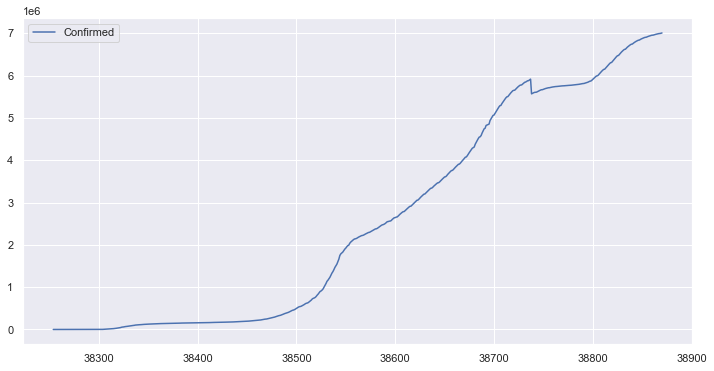

In [24]:
sns.lineplot(
    data = covid_data
)

We process our time series : differencing + moving average + sliding window

In [25]:
seq_length = 15
average_size = 3
train_proportion = 2/3
scaler4 = MinMaxScaler(feature_range=(-1, 1))
y_raw4, X_data4, y_data4, X_train4, y_train4, X_test4, y_test4 = process_data_diff(covid_data, seq_length, average_size, train_proportion, scaler4)

In [26]:
my_model4 = LstmNeuralNetwork(input_size = 1, num_layers = 2, hidden_size = 21, seq_length = seq_length)

In [24]:
num_epochs = 2000
learning_rate = 0.01
criterion = nn.MSELoss()
my_model4._train(num_epochs, learning_rate, criterion, X_train4, y_train4, X_test4, y_test4)

Epoch: 100, Train loss: 0.00881, Test loss: 0.12115: 100%|██████████| 101/101 [00:03<00:00, 30.60it/s]


In [28]:
filepath4 = 'save/model4'
torch.save(my_model4.state_dict(), filepath4)

In [27]:
filepath4 = 'save/model4'
my_model4.load_state_dict(torch.load(filepath4))

<All keys matched successfully>

<Figure size 864x432 with 0 Axes>

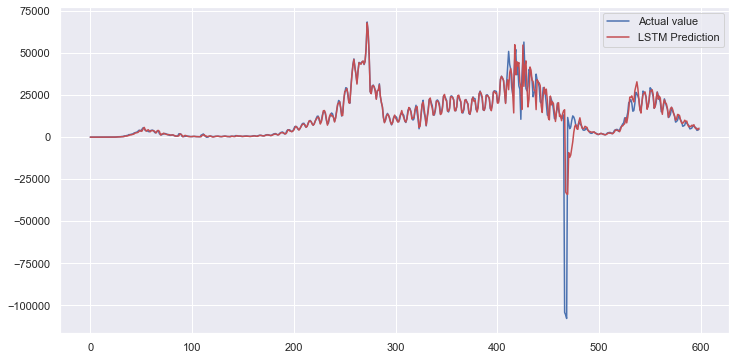

In [29]:
plt.clf()
plt.figure(figsize=(12,6))
my_model4.plot(X_data4, y_data4, scaler4)

<Figure size 864x432 with 0 Axes>

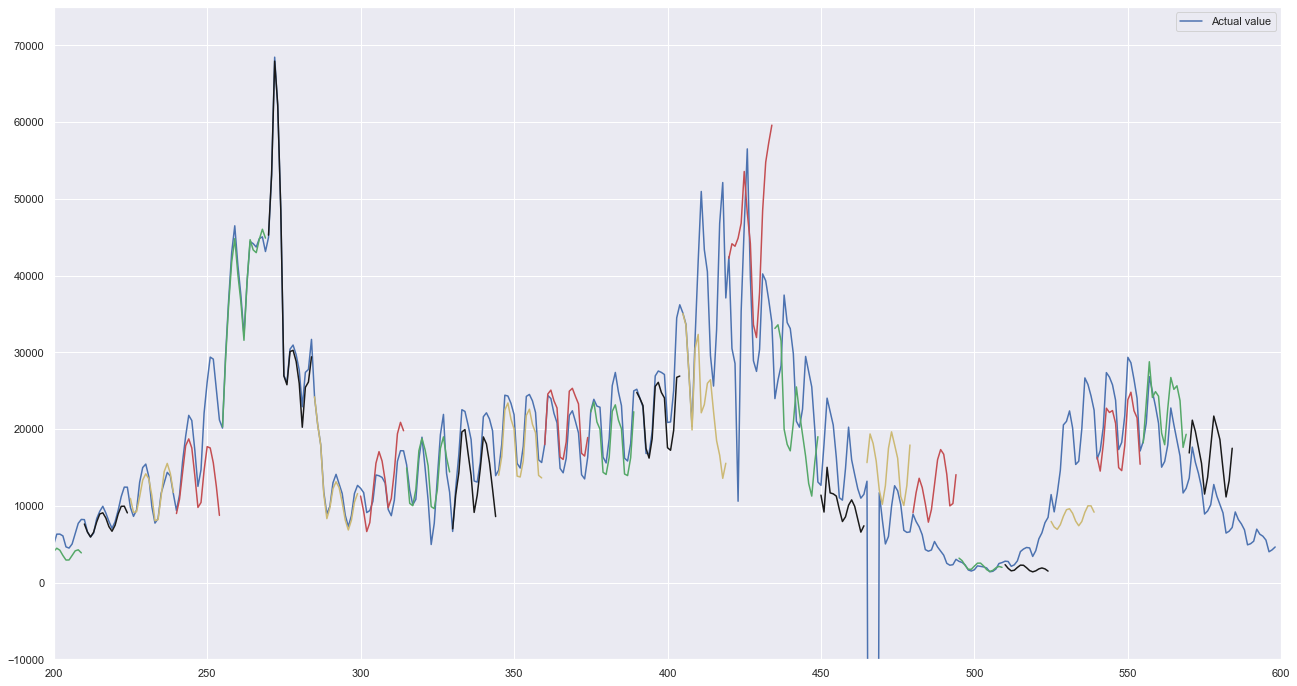

In [30]:
horizon = 15
drawing_jump = 15
plt.clf()
plt.figure(figsize=(22,12))
plt.axis([200, 600, -10000, 75000])
my_model4.plot_with_horizon(X_data4, y_data4, scaler4, horizon, drawing_jump)

In [31]:
last_day = y_data4.shape[0]
horizon_1 = 1
horizon_2 = 7
horizon_3 = 15
naive_prediction_without_horizon4 = np.zeros(last_day)
print('Model accuracy with horizon = 1: \n')
my_model4.get_accuracy_with_horizon(X_data4, y_data4, naive_prediction_without_horizon4, scaler4, last_day, horizon_1)
print('\nModel accuracy with horizon = 7: \n')
my_model4.get_accuracy_with_horizon(X_data4, y_data4, naive_prediction_without_horizon4, scaler4, last_day, horizon_2)
print('\nModel accuracy with horizon = 15: \n')
my_model4.get_accuracy_with_horizon(X_data4, y_data4, naive_prediction_without_horizon4, scaler4, last_day, horizon_3)

Model accuracy with horizon = 1: 

Mean squared error up to the 599 day using the naive prediction : 356789634.5978947
Mean squared error up to the 599 day using the lstm prediction : 57304908.824564785
R2 up to the 599 day using the naive prediction : -0.6207198711709523
R2 up to the 599 day using the lstm prediction : 0.7396919768919772

Model accuracy with horizon = 7: 

Mean squared error up to the 599 day using the naive prediction : 360281969.6920421
Mean squared error up to the 599 day using the lstm prediction : 107023304.61249377
R2 up to the 599 day using the naive prediction : -0.6271059104118122
R2 up to the 599 day using the lstm prediction : 0.5166612094531393

Model accuracy with horizon = 15: 

Mean squared error up to the 599 day using the naive prediction : 364959351.51602685
Mean squared error up to the 599 day using the lstm prediction : 121971782.64713778
R2 up to the 599 day using the naive prediction : -0.6347817928788655
R2 up to the 599 day using the lstm predi

On the plot with an horizon of 15 days, we notice that our model was able to learn the weak seasonality in the covid cases. Furthermore, we see on the $R^2$ values that our model still gets $R^2 = 0.45$ with a 15 days horizon. 